 master-thesisInput:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


In [3]:
#%cd ..

In [4]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *

## Optimization Settings

In [5]:
observation = 'hospitalization' #'newly_infected' #'hospitalization'
rolling_avg_obs = 2
# Overall Time Period
start_time='2020-08-01' # Mitte November/ Anfang Dezember bis Februar
end_time='2021-02-01' # Begin Vaccination Wave


dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

## Initialize Observations

In [6]:
df_obs_initial = pd.read_csv('data/220309_observations.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])

# Initialize Observations Training
df_obs, initial_newly_infected = initialize_observations(df_obs_initial, start=start_time, end=end_time, rolling_avg=rolling_avg_obs)
observed_train = torch.tensor(df_obs[observation], requires_grad=False, device=device, dtype=dtype)

df_obs.head(3)

,Date,number_of_deaths,newly_infected,hospitalization
0,2020-08-01,0.5,61.0,3.5
1,2020-08-02,0.0,71.0,3.0
2,2020-08-03,0.0,97.5,4.5


In [7]:
#for column in df_obs.columns:
#  plt.plot(df_obs['Date'], df_obs[column])
#  plt.title(column)
#  plt.show()

## Initialize Model Parameter

### Initialize helper parameter

In [8]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)

### Initialize method parameter

In [9]:
method = TwoClusterLinear(device=device, dtype=dtype)

### Initialize alpha and phi

In [10]:
dict_param = initialize_parameter(['alpha', 'phi'], device, dtype)
dict_param

{'prime_values': {'alpha': tensor(0.0102, requires_grad=True),
  'phi': tensor(-0.0020, requires_grad=True)},
 'real_values': {'alpha': tensor(0.0280, grad_fn=<AddBackward0>),
  'phi': tensor(25., grad_fn=<AddBackward0>)}}

## Load Method Input Data

In [11]:
method.set_cluster_train(start_time, end_time)

In [12]:
method.cluster_percentage_train.shape

(184,)

# Optimization

## Training

Step: 0, Learning Rate: 0.00999 Time: 0.1463, Comparison Loss: 114345.921875


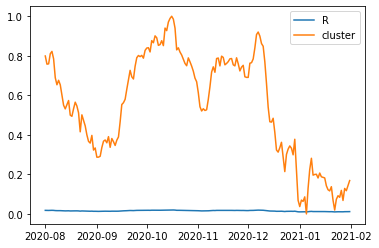

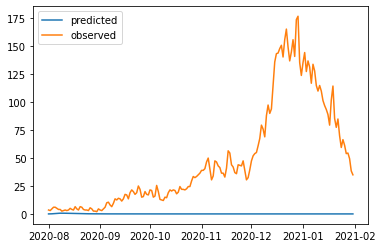

Step: 50, Learning Rate: 0.00950254422568834 Time: 0.1201, Comparison Loss: 111964.546875


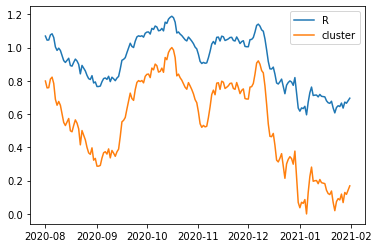

Step: 100, Learning Rate: 0.009038873549665948 Time: 0.1017, Comparison Loss: 4996.7578125


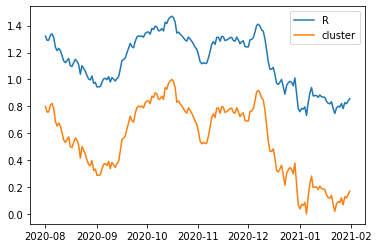

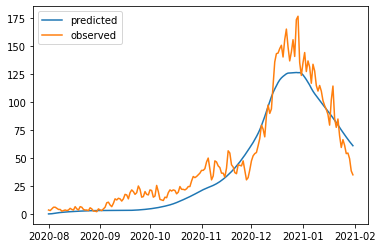

Step: 150, Learning Rate: 0.008597827393003531 Time: 0.0658, Comparison Loss: 4249.5908203125


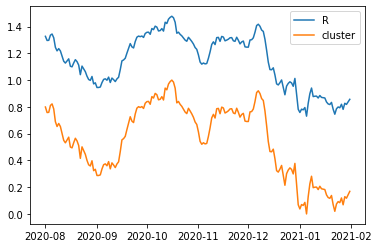

Step: 200, Learning Rate: 0.008178301806491574 Time: 0.0895, Comparison Loss: 4190.19921875


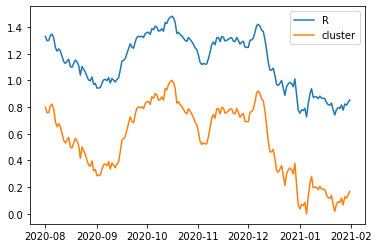

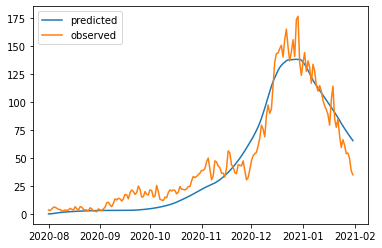

Step: 250, Learning Rate: 0.00777924670742873 Time: 0.0599, Comparison Loss: 4137.40966796875


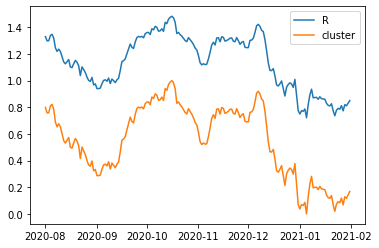

Step: 300, Learning Rate: 0.007399663251239432 Time: 0.073, Comparison Loss: 4092.127197265625


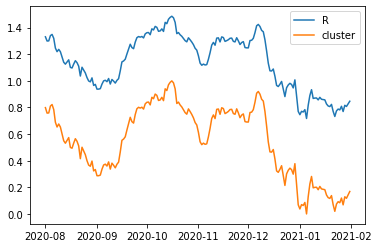

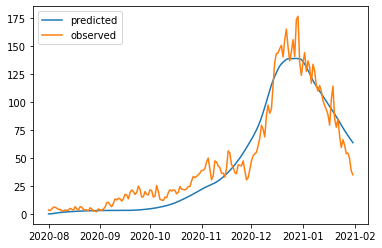

Step: 350, Learning Rate: 0.007038601331341688 Time: 0.0707, Comparison Loss: 4054.273193359375


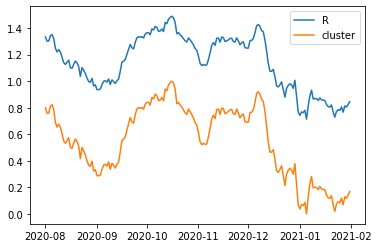

Step: 400, Learning Rate: 0.006695157201007331 Time: 0.0703, Comparison Loss: 4023.1796875


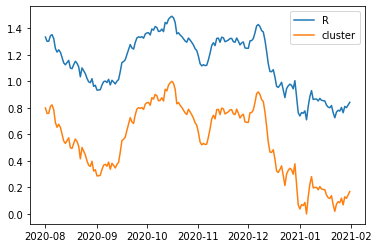

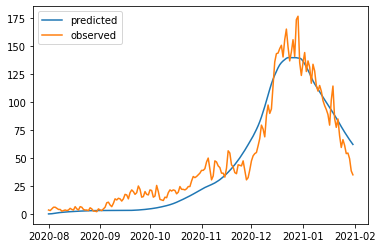

Step: 450, Learning Rate: 0.006368471211262053 Time: 0.0749, Comparison Loss: 3997.940185546875


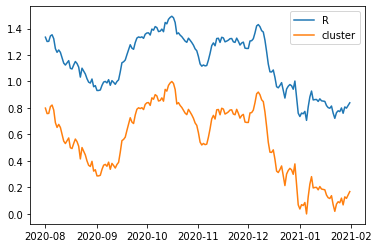

Step: 500, Learning Rate: 0.006057725659163231 Time: 0.0721, Comparison Loss: 3977.59716796875


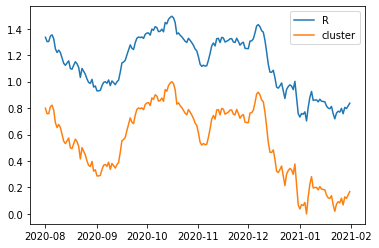

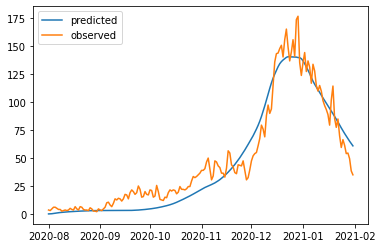

Step: 550, Learning Rate: 0.0057621427410696376 Time: 0.0652, Comparison Loss: 3961.262451171875


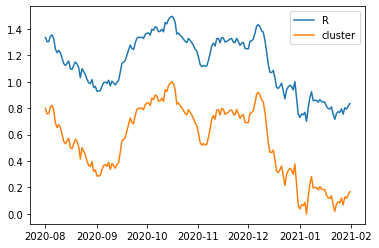

Step: 600, Learning Rate: 0.005480982605780108 Time: 0.0863, Comparison Loss: 3948.15283203125


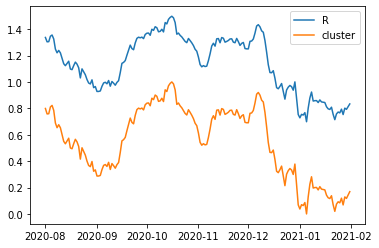

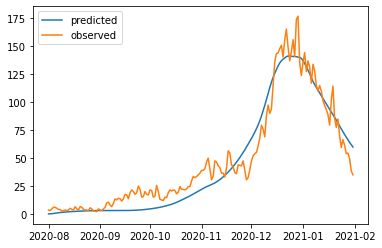

Step: 650, Learning Rate: 0.005213541502668067 Time: 0.0603, Comparison Loss: 3937.6103515625


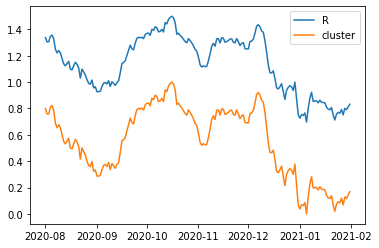

Step: 700, Learning Rate: 0.004959150020176671 Time: 0.0656, Comparison Loss: 3929.093017578125


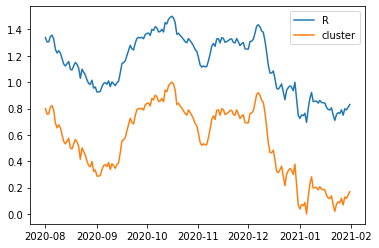

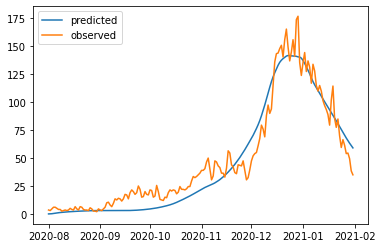

Step: 750, Learning Rate: 0.004717171410265472 Time: 0.0657, Comparison Loss: 3922.1640625


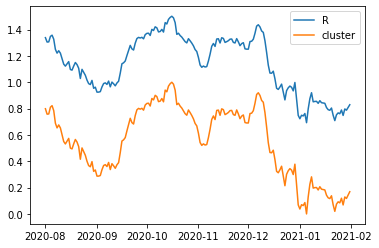

Step: 800, Learning Rate: 0.004486999994614646 Time: 0.0768, Comparison Loss: 3916.475830078125


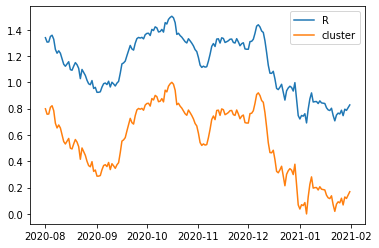

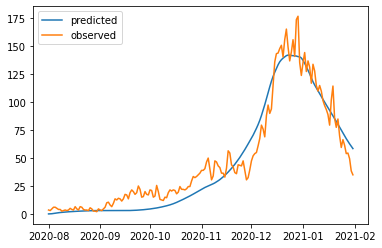

Step: 850, Learning Rate: 0.004268059648597501 Time: 0.0625, Comparison Loss: 3911.75732421875


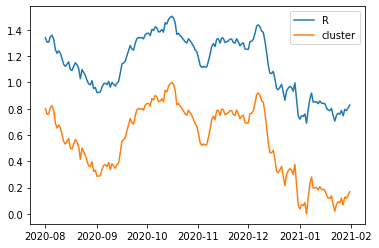

Step: 900, Learning Rate: 0.0040598023592265855 Time: 0.0704, Comparison Loss: 3907.79296875


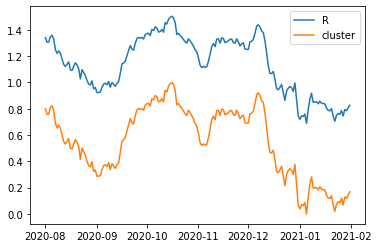

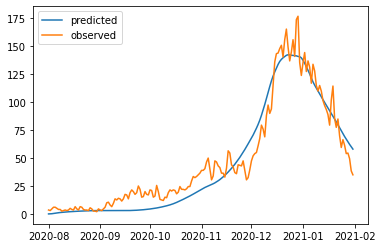

Step: 950, Learning Rate: 0.0038617068534639145 Time: 0.0656, Comparison Loss: 3904.418212890625


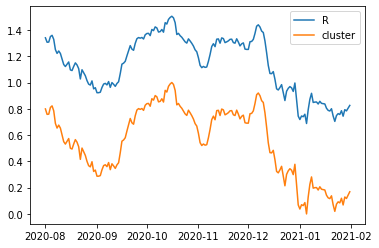

In [13]:
from torch.optim.lr_scheduler import ExponentialLR

epochs = 1000
# model_parameter = [dict_param['prime_values']['alpha'], dict_param['prime_values']['phi']] + [dict_param['prime_values']['epsilon']]

params_to_be_optimized = method.get_parameters() + [dict_param['prime_values']['phi']]
if observation == 'hospitalization':
  params_to_be_optimized = params_to_be_optimized + [dict_param['prime_values']['alpha']]

optimizer = optim.Adam(params_to_be_optimized, lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.999)

for i in range(epochs):
  iteration_time = time.time()
  optimizer.zero_grad()

  # transform alphi, phi
  dict_param = transform_prime_variables(dict_param)

  # forward pass
  expected = epid_model(R=method.calculate_R(method.cluster_percentage_train), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
  
  # calc loss
  comparison_loss_train =  calc_mse(expected, observed_train) * dict_param['real_values']['phi'] #calc_negative_binomnial_loss(expected, observed_train, dict_param['real_values']['phi']) #
  method_loss = method.calculate_loss()
  model_param_loss = calc_prior_loss(dict_param, device, dtype)
  loss = comparison_loss_train + method_loss + model_param_loss

  # backward pass
  loss.backward()
  optimizer.step()
  scheduler.step()
  
  
  with torch.no_grad():
    if i % 50==0:
        current_time = round((time.time() - iteration_time),4)
        current_lr = optimizer.state_dict()['param_groups'][0]['lr']
        print(f"Step: {i}, Learning Rate: {current_lr} Time: {current_time}, Comparison Loss: {comparison_loss_train}")
        plt.plot(df_obs['Date'], method.calculate_R(method.cluster_percentage_train).cpu().detach().numpy(), label='R')
        plt.plot(df_obs['Date'], method.cluster_percentage_train, label='cluster')
        plt.legend()
        plt.show()
    if i % 100==0:
      plt.plot(df_obs['Date'], expected.cpu().detach().numpy(), label='predicted')
      plt.plot(df_obs['Date'], observed_train.cpu().detach().numpy(), label='observed')
      plt.legend()
      plt.show()

In [14]:
comparison_loss_train / dict_param['real_values']['phi']

tensor(158.1059, grad_fn=<DivBackward0>)

# Evaluation

## Train and Test Time 

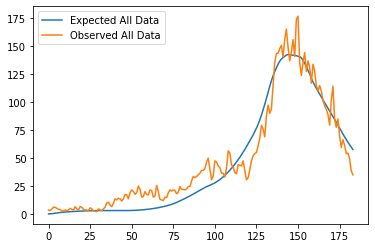

In [15]:
plt.plot(expected.cpu().detach().numpy(),label='Expected All Data')
plt.plot(observed_train.cpu().detach().numpy(),label='Observed All Data')
plt.legend()
plt.show()

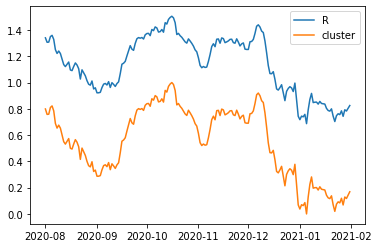

In [16]:
# Plot R-Value & Cluster Percentage
plt.plot(df_obs['Date'], method.calculate_R(method.cluster_percentage_train).cpu().detach().numpy(), label='R')
plt.plot(df_obs['Date'], method.cluster_percentage_train, label='cluster')
plt.legend()
plt.show()

## Eval What IF

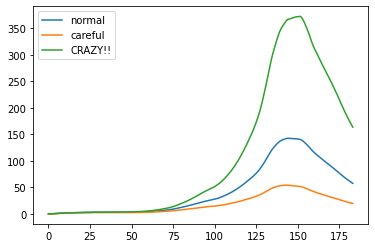

In [17]:
expected_normal = epid_model(R=method.calculate_R(method.cluster_percentage_train), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
expected_careful= epid_model(R=method.calculate_R(method.cluster_percentage_train*0.9), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
expected_crazy = epid_model(R=method.calculate_R(method.cluster_percentage_train*1.1), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]

plt.plot(expected_normal.cpu().detach().numpy(),label='normal')
plt.plot(expected_careful.cpu().detach().numpy(),label='careful')
plt.plot(expected_crazy.cpu().detach().numpy(),label='CRAZY!!')
plt.legend()
plt.show()

## Eval Cluster Percentage vs R-Value

Slope: 0.8175593039013305, intercept: 0.6872547556649964, r-squared: 0.9999999999999771


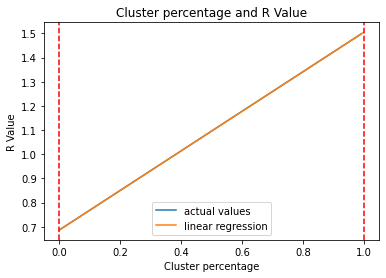

In [18]:
from scipy import stats

x = np.arange(0,1 , 0.01)
y = np.squeeze(method.calculate_R(x).cpu().detach().numpy())


x_min = method.cluster_percentage_train.min()
x_max = method.cluster_percentage_train.max()
x_bound = np.arange(x_min, x_max + 0.01 , 0.01)
y_bound = np.squeeze(method.calculate_R(x_bound).cpu().detach().numpy())

slope, intercept, r_value, p_value, std_err = stats.linregress(x_bound, y_bound)
y_linreg = intercept + slope * x_bound
print(f'Slope: {slope}, intercept: {intercept}, r-squared: {r_value**2}')
plt.plot(x, y, label='actual values')
plt.plot(x_bound, y_linreg, label='linear regression')
plt.axvline(x=x_min, c='r', linestyle='--')
plt.axvline(x=x_max, c='r', linestyle='--')
plt.xlabel('Cluster percentage')
plt.ylabel('R Value')
plt.title('Cluster percentage and R Value')
plt.legend()
plt.show()

Eval Newly Infected

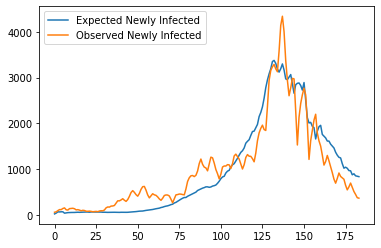

In [19]:
expected_newly = epid_model(R=method.calculate_R(method.cluster_percentage_train), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)['newly_infected']

plt.plot(expected_newly.cpu().detach().numpy(),label='Expected Newly Infected')
plt.plot(df_obs['newly_infected'],label='Observed Newly Infected')
plt.legend()
plt.show()